<a href="https://colab.research.google.com/github/xiaoras/superheroes-notebook/blob/master/superheroes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is designed to be run in Google Colab with runtime type set to GPU.

## Introduction

This notebook contains the code used to train my superhero image classifier (find the internet app [here](https://superheroes.onrender.com)). The notebook relies on FastAi (a deep learning framework based on PyTorch), and is based on a ResNet34 architecture.

The input is a `superheroes.tar.gz` file, which contains a dataset of superheroes images -- please follow the instructions below to see how to upload this file to Colab.

The output is a `export.pkl` file containing the trained model. This can then be copied to another machine and loaded, so as to perform inference (see the "Production" section at the end of the notebook).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

### FastAi: data preprocessing tools
from fastai.vision import ImageList, DataBunch, get_transforms, imagenet_stats

### FastAi: model and metrics tools
from fastai.vision import cnn_learner, models
from fastai.metrics import accuracy

### FastAi: interpretation tools
from fastai.vision import ClassificationInterpretation

### FastAi: production
from fastai.basic_train import load_learner
from fastai.vision import open_image

## Getting the Data

First, let us import the data for training. The dataset can be found [here](https://drive.google.com/uc?export=download&id=1gKQoZbwNVLdxXKvYbqaHJVPzlIH1Rur4): it is a file called `superheroes.tar.gz`.

Download the file on your machine and then upload it to Colab by simply dragging and dropping it in the "Files" tab on the left. Be patient: it will take some minutes to upload the file, since it is quite large (it contains several hundred images).

Once the file has been uploaded, let us create a "superheroes" folder: this is where we will extract the archive.

In [3]:
!mkdir superheroes

Finally, let us extract the data:

In [4]:
!tar -xf  'superheroes.tar.gz' -C '/content/superheroes'

## Data Preprocessing

The data consists of jpg images arranged in folders named after the corresponding category. We therefore need to preprocess these images in order to prepare them to be used by the model. This is most easily done via the data block API provided by FastAi.

First, we create an `ImageList` object based on the folder structure:

In [5]:
il = ImageList.from_folder('superheroes')

Next, we randomnly split it into "training set" and "validation set", using 20% of the images for the latter:

In [6]:
sd = il.split_by_rand_pct(valid_pct=0.2)

At this point, we turn the `ImageList` into a `LabelLists`, also based on the folder structure:

In [7]:
ll = sd.label_from_folder()

It is now time to perform data augmentation: this step ensures that the images are transformed (i.e., rotated, zoomed, slightly warped), so as to increase the variability of the dataset.

In [8]:
trfm = get_transforms(do_flip=False, flip_vert=False, max_zoom=1)

ll = ll.transform(trfm, size=224)

Next, we create a `DataBunch` object, which is the data loader for the model:

In [9]:
data = ll.databunch()

Finally, we perform feature normalization using the ImageNet statistics. We do so (instead of deriving mean and standard deviation from our dataset) because we will be using a pre-trained model based on the ImageNet database.

In [10]:
data = data.normalize(imagenet_stats)

We can now take a look at some samples in our dataset:

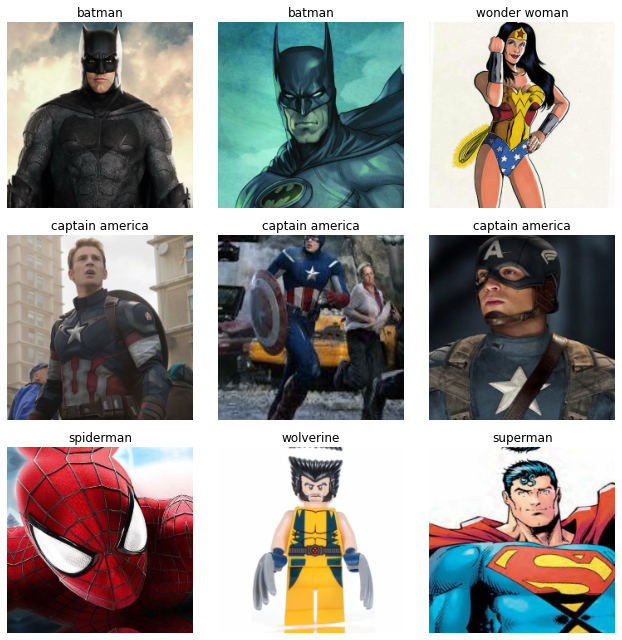

In [11]:
data.show_batch(rows=3, figsize=(9, 9))

We can also look at single images within the training and validation datasets, `data.train_ds` and `data.valid_ds` respectively:

captain america


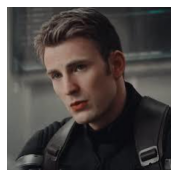

In [12]:
x, y = data.valid_ds[0]
print(y)
x.show()

## Model and Training

Now that the data is ready, we define the model: we will use a pre-trained resnet34 network:

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Let us confirm that `learn` contains the right categories:

In [14]:
print(learn.data.c)
learn.data.classes

9


['batman',
 'captain america',
 'deadpool',
 'hulk',
 'iron man',
 'spiderman',
 'superman',
 'wolverine',
 'wonder woman']

We are now ready to train our model. We will start with 5 epochs. Since we did not specify the loss function nor the optimizer, the defaults (which are cross entropy loss and ADAM, respectively) will be used.

In [15]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.894899,1.208515,0.588889,00:20
1,1.838421,0.700537,0.783333,00:20
2,1.305917,0.610883,0.794444,00:20
3,0.973103,0.583243,0.805556,00:20
4,0.773928,0.587128,0.816667,00:20


Let us save the learned weights:

In [16]:
learn.save('1')

Next, we unfreeze the model. Indeed, in the previous training, only the last layer of the ResNet was trained, as this is the default. We now fine-tune all the layers.

In [17]:
learn.unfreeze()

To help ourselves finding a good learning rate, we use the `lr_find()` method:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


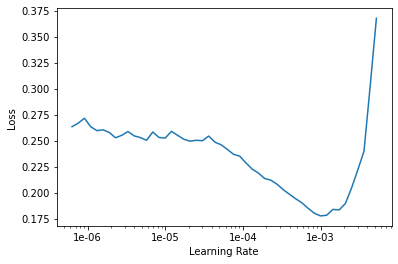

In [18]:
learn.lr_find()
learn.recorder.plot()

We then pick the learning rate for which the curve is following a steepest descent, and train for another couple of epochs.

In [19]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.274016,0.480180,0.850000,00:20
1,0.206512,0.443170,0.850000,00:20


In [20]:
learn.save('2')

## Interpretation

Now that the model has been trained for a while, we can take a look at the confusion matrix, to get an idea where is the model behaving bad:

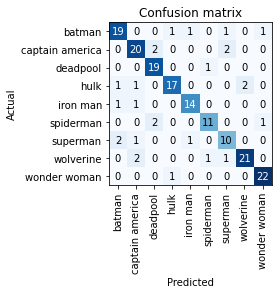

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We can also take a look at what samples are the "most wrong" ones (i.e., those which are misclassified with the highest level of confidence):

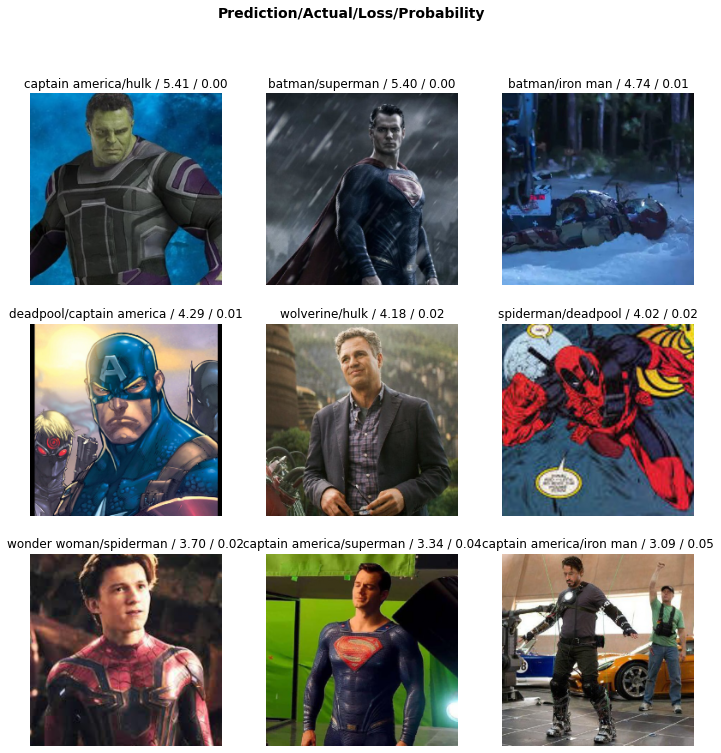

In [22]:
interp.plot_top_losses(9, figsize=(12, 12))

This allows us to see whether some images are really bad (i.e., a human would also not be able to correctly classify them), and in that case eliminate them from the dataset.

## Production

The model is now ready, so we use the `export()` method. This will create a `export.pkl` file in the `superhero` folder. This file is  what you would need in order to deploy the model on a different machine. For example, for the internet application found [here](https://superheroes.onrender.com) (see also the app's [repository](https://github.com/xiaoras/superheroes/tree/master) for details on how the model is actually deployed online).

In [23]:
learn.export()

Once we have the file `export.pkl`, we can also import it using the `load_learner` command:

In [24]:
path = Path('superheroes')
learn_loaded = load_learner(path)

Now, given an image, we open it and feed it to the model, using the `predict` method:

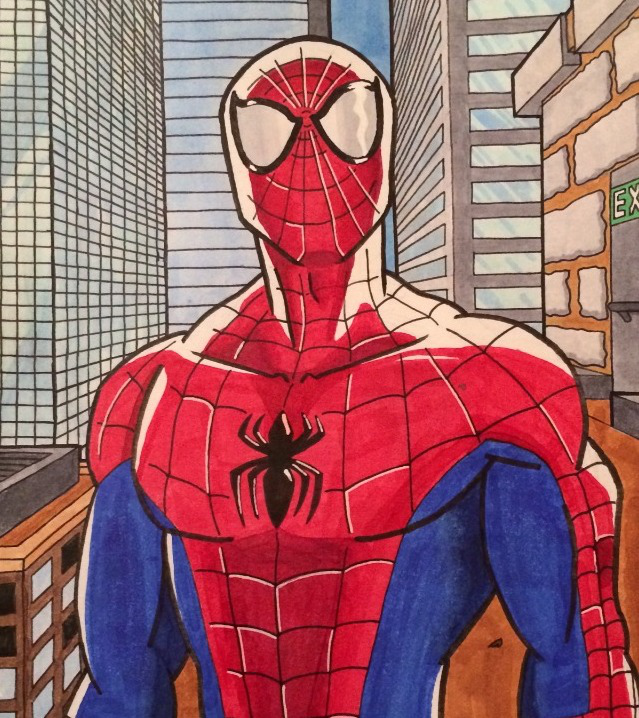

In [25]:
img = open_image('superheroes/spiderman/1000.jpg')
img

In [26]:
pred_class, pred_idx, outputs = learn_loaded.predict(img)
learn_loaded.data.classes[pred_idx]

'spiderman'

The `outputs` variable contains the probabilities for each category. We can visualize them with a histogram:

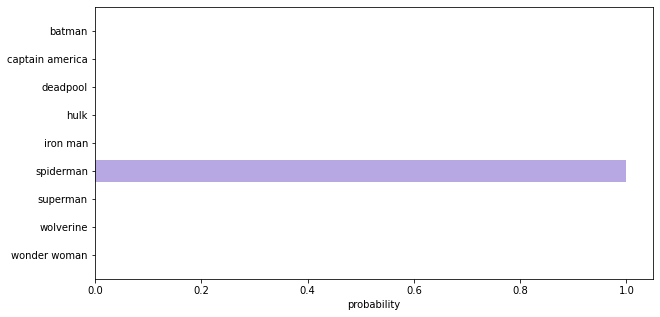

In [27]:
categories = learn.data.classes
probabilities = [float(outputs[i]) for i in range(len(categories))]

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(categories, probabilities, color='#7052CB', alpha=0.5)
ax.invert_yaxis()
ax.set_xlabel('probability')
plt.show()